# 卒業研究14：実験データのガウス過程回帰
#### 坂西和也

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
import os

# カレントディレクトリを取得
data_path = os.getcwd()

In [21]:
# CSVファイルを読み込む 
data = pd.read_csv(data_path + '/AbExist.csv' , delimiter=r'\t')
# 列名を修正
data = data.rename(columns={'"S8SVel02Scaled': 'S8SVel02Scaled', 'S8SRuma030"': 'S8SRuma030'})

# 余分なダブルクォーテーションを取り除く
data["S8SVel02Scaled"] = data["S8SVel02Scaled"].str.replace('"', '').astype(float)
data["S8SRuma030"] = data["S8SRuma030"].str.replace('"', '').astype(int)

 /tmp/ipykernel_990140/1475238272.py:2: ParserWarning:Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


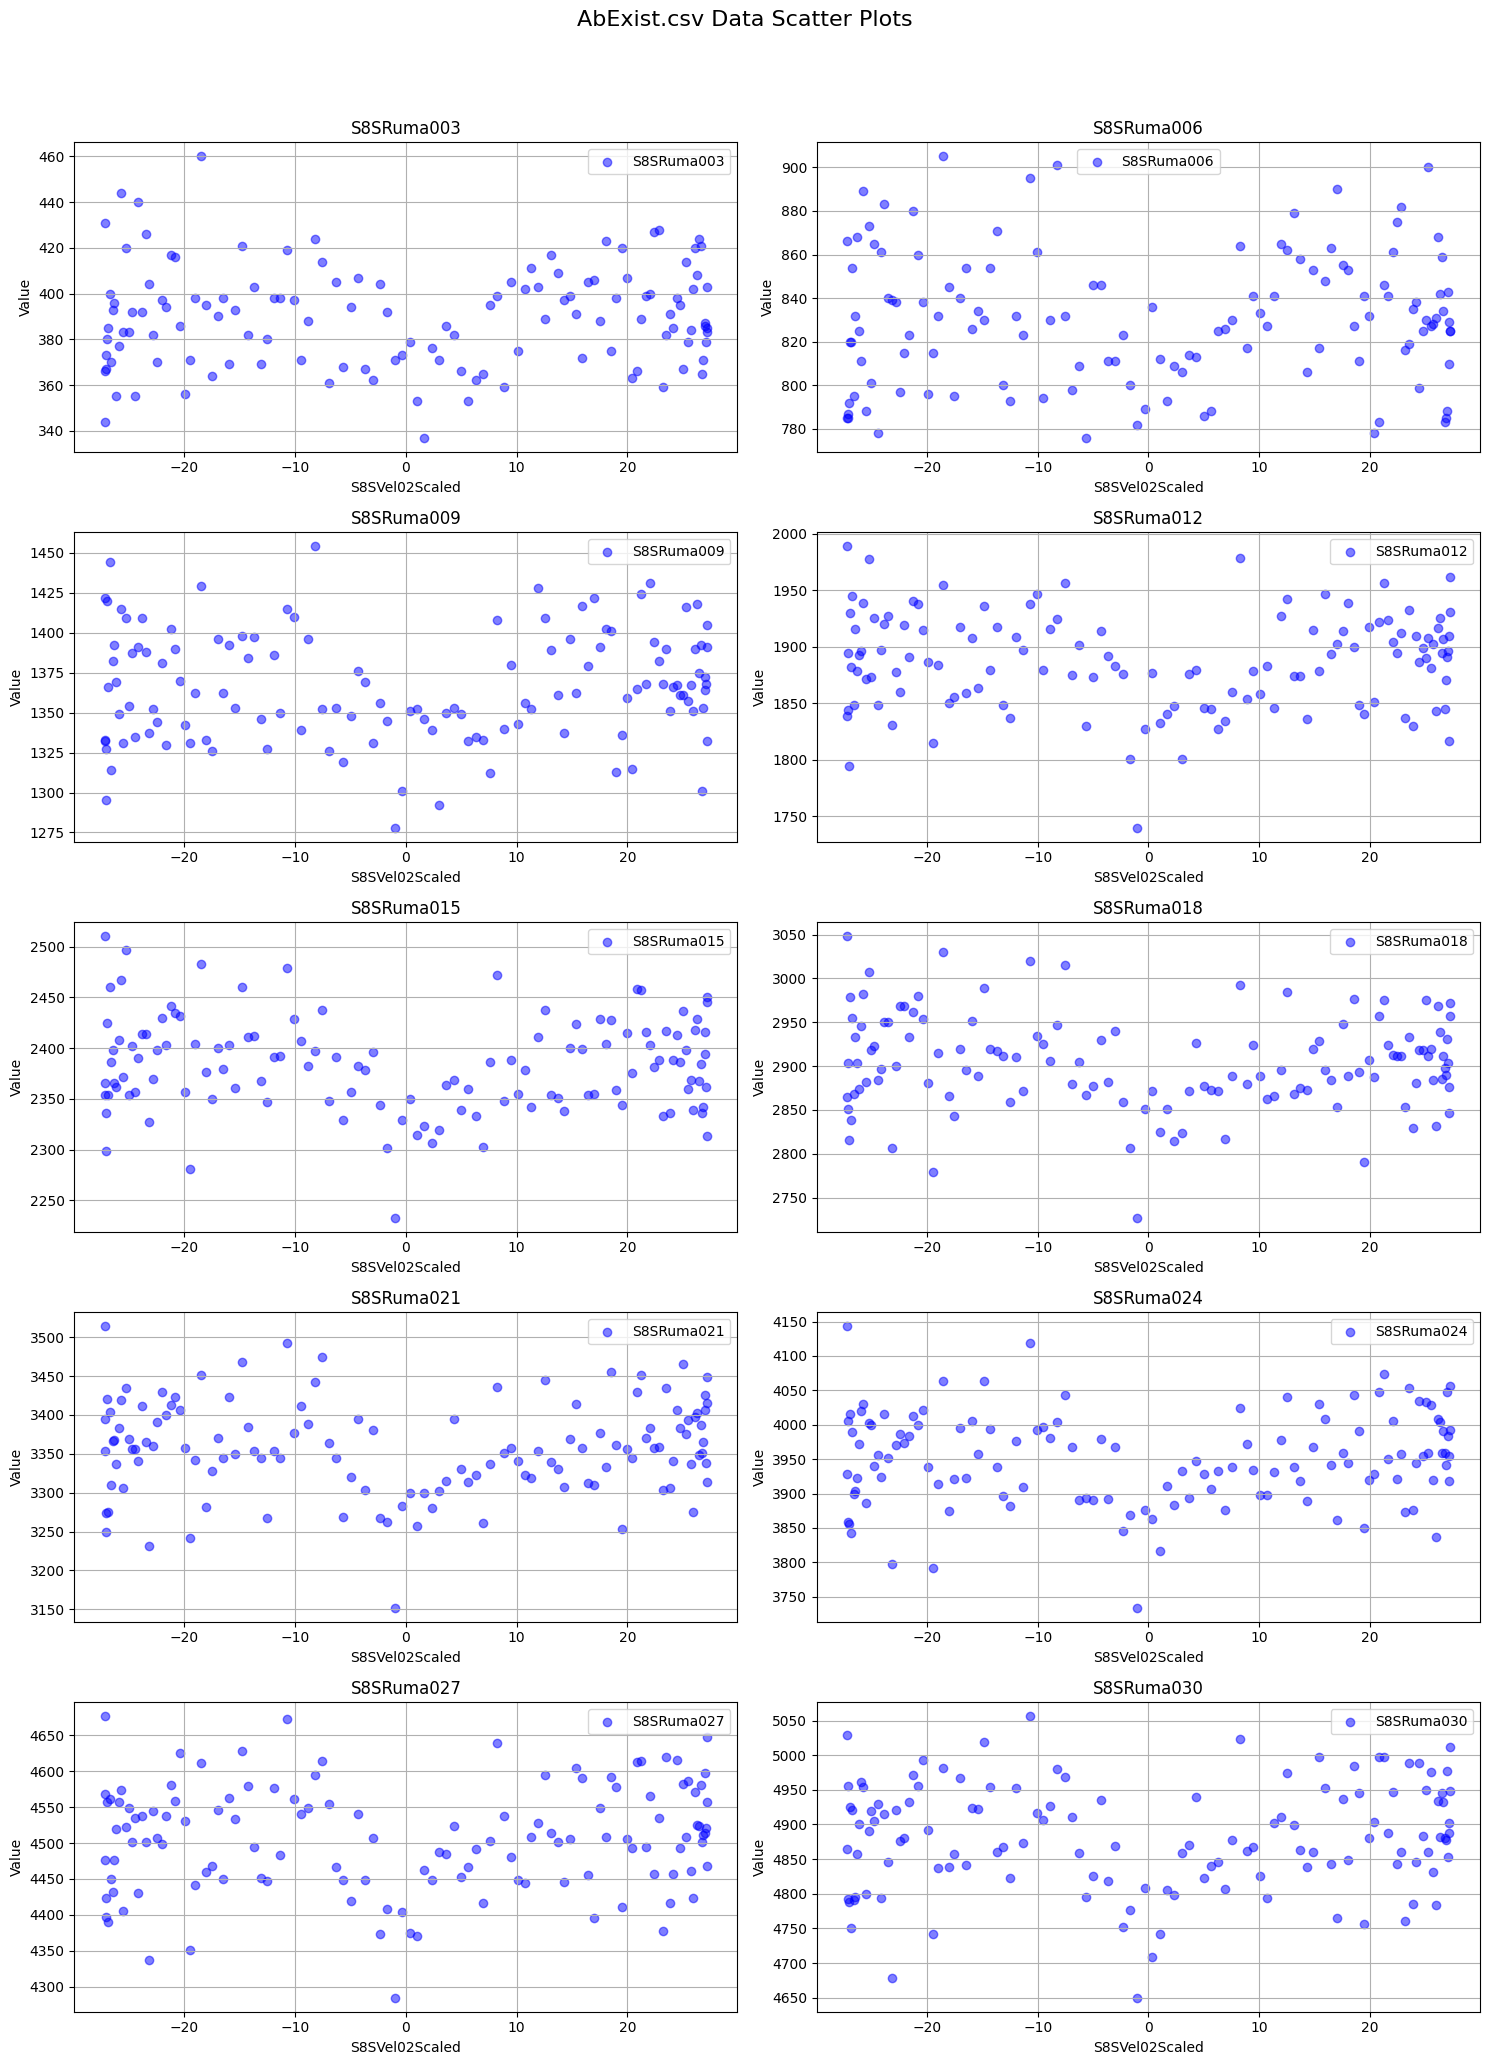

In [22]:
# AbExist.csvのデータを散布図で可視化
fig, axs = plt.subplots(5, 2, figsize=(15, 20))
fig.suptitle('AbExist.csv Data Scatter Plots', fontsize=16, y=1.03)
columns = data.columns[1:]
x = data['S8SVel02Scaled']
for i, ax in enumerate(axs.flat):
    ax.scatter(x, data[columns[i]], label=columns[i], color='b', alpha=0.5)
    ax.set_title(columns[i])
    ax.set_xlabel('S8SVel02Scaled')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

## ガウス過程回帰で再現

### RBFカーネル
$$
k(x , x^{\prime}) =\sigma^2 \exp \left( - \frac{|| x - x^{\prime} || ^2}{2 l^2}  \right)
$$

In [23]:
import GPy

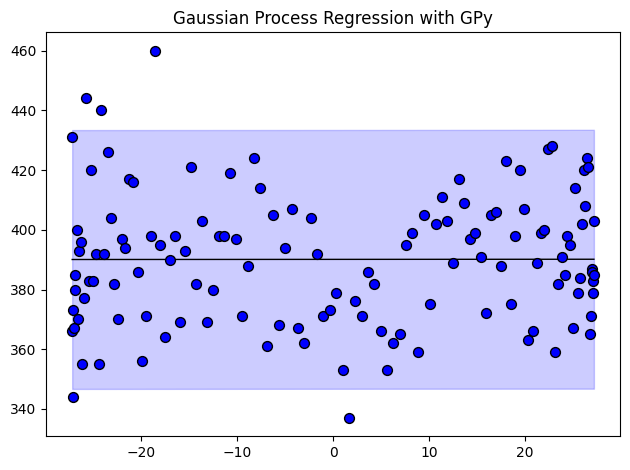

In [24]:
# データの読み込み
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 1].values.reshape(-1, 1)

# ガウス過程モデルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with GPy")
plt.tight_layout()
plt.show()

#### ハイパーパラメータ

In [25]:
# カーネルの分散 (σ^2)
variance = model.kern.variance[0]

# カーネルの長さスケール (l)
lengthscale = model.kern.lengthscale[0]

variance, lengthscale

(118212.16778366153, 18952.37345018427)

## 指数カーネル
$$
k(x , x^{\prime}) =\sigma^2 \exp \left( - \frac{|| x - x^{\prime} || }{ l}  \right)
$$

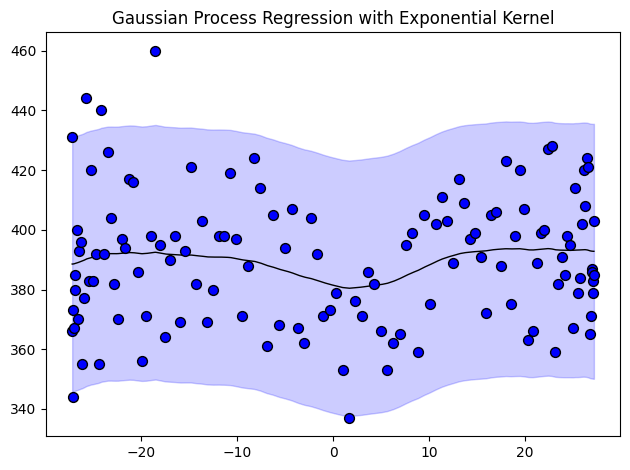

In [27]:
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# データの読み込み
X = data.iloc[:, 0].values.reshape(-1, 1)
y = data.iloc[:, 1].values.reshape(-1, 1)

# 指数カーネルを使用したガウス過程モデルの定義
kernel = GPy.kern.Exponential(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with Exponential Kernel")
plt.tight_layout()
plt.show()


### ハイパーパラメータ

In [28]:
# カーネルの分散 (σ^2)
variance = model.kern.variance[0]

# カーネルの長さスケール (l)
lengthscale = model.kern.lengthscale[0]

variance, lengthscale

(142593.27721686265, 43162.45848832192)

## 周期カーネル

$$
k(x , x^{\prime}) =\exp \left( \theta_1 \cos\left( \frac{|x - x^{\prime}|}{\theta_2} \right) \right)
$$

Custom Periodic kernel parameters:
Theta_1: 25.24185109753276
Theta_2: 38.20970057105373


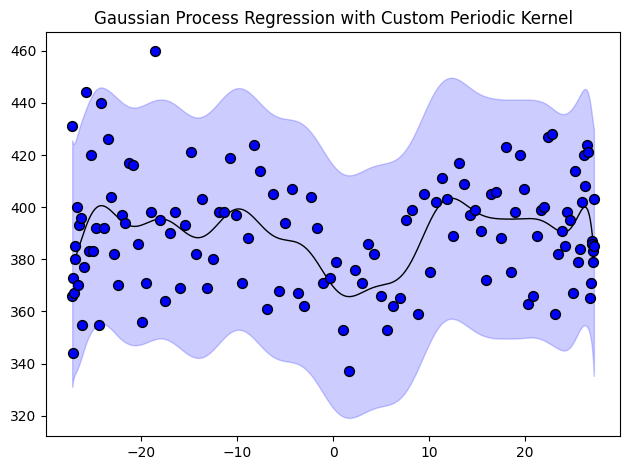

In [29]:
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt

# カスタムの周期カーネルを定義
class CustomPeriodicKernel(GPy.kern.Kern):
    def __init__(self, input_dim, theta_1=1.0, theta_2=1.0, active_dims=None):
        super(CustomPeriodicKernel, self).__init__(input_dim, active_dims, 'custom_periodic')
        self.theta_1 = GPy.Param('theta_1', theta_1)
        self.theta_2 = GPy.Param('theta_2', theta_2)
        self.link_parameters(self.theta_1, self.theta_2)
    
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        dist = np.abs(X - X2.T)
        return np.exp(self.theta_1 * np.cos(dist / self.theta_2))

    def Kdiag(self, X):
        return np.exp(self.theta_1) * np.ones(X.shape[0])

    def update_gradients_full(self, dL_dK, X, X2=None):
        if X2 is None:
            X2 = X
        dist = np.abs(X - X2.T)
        
        dK_dtheta1 = np.cos(dist / self.theta_2)
        dK_dtheta2 = self.theta_1 * np.sin(dist / self.theta_2) * dist / (self.theta_2**2)
        
        self.theta_1.gradient = np.sum(dL_dK * dK_dtheta1)
        self.theta_2.gradient = np.sum(dL_dK * dK_dtheta2)

# カーネルのインスタンスを作成
kernel = CustomPeriodicKernel(input_dim=1)

# ガウス過程モデルの定義
model = GPy.models.GPRegression(X, y, kernel)

# モデルの最適化
model.optimize(messages=True)

# ハイパーパラメータの値を表示
print("Custom Periodic kernel parameters:")
print(f"Theta_1: {model.kern.theta_1[0]}")
print(f"Theta_2: {model.kern.theta_2[0]}")

# 予測
X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
y_pred, var_pred = model.predict(X_pred)
y_pred = y_pred.ravel()
sigma = np.sqrt(var_pred).ravel()

# 結果のプロット
plt.figure()
plt.plot(X_pred, y_pred, 'k', lw=1)
plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Gaussian Process Regression with Custom Periodic Kernel")
plt.tight_layout()
plt.show()


In [31]:
X = data.iloc[:, 0].values[:, np.newaxis] # 1列目を独立変数として使用

Custom Periodic kernel parameters for S8SRuma003:
Theta_1: 25.241851097544593
Theta_2: 38.20970057105352


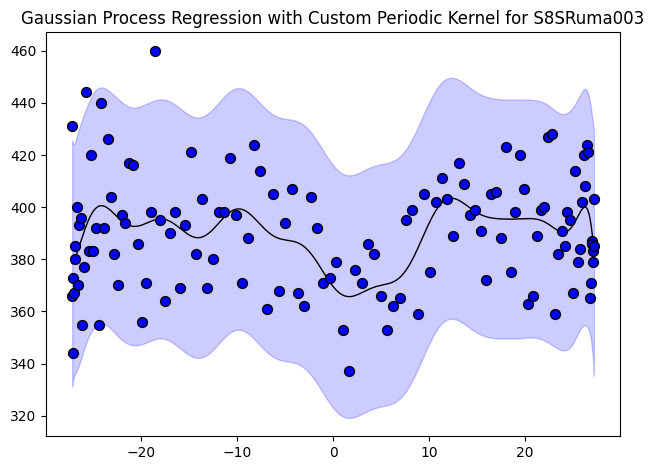

Custom Periodic kernel parameters for S8SRuma006:
Theta_1: 22.266005901739888
Theta_2: 13.225331488113195


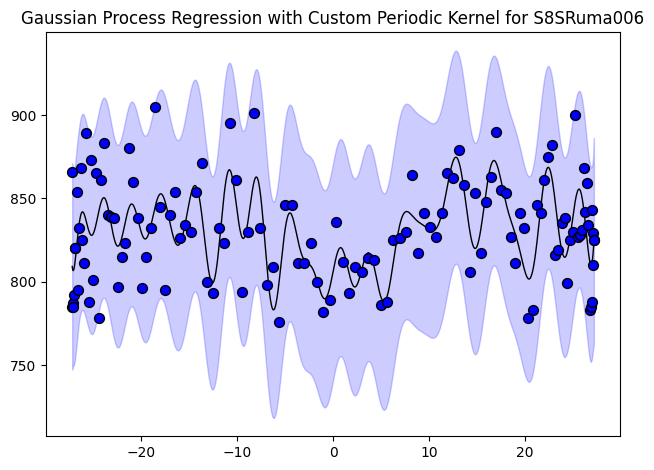

Custom Periodic kernel parameters for S8SRuma009:
Theta_1: 1.0012248871028868
Theta_2: -0.45098122795633055


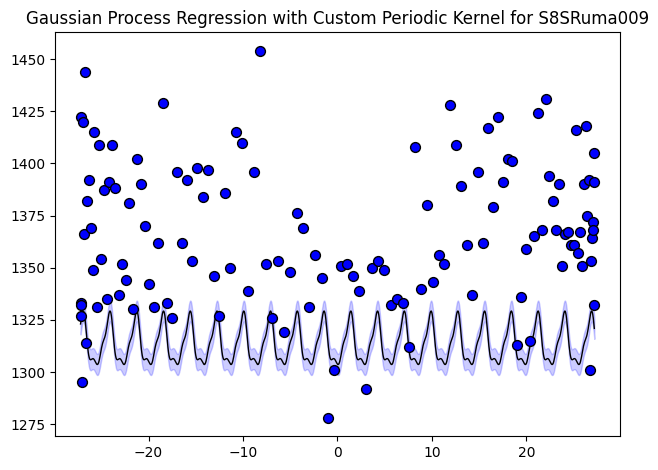

Custom Periodic kernel parameters for S8SRuma012:
Theta_1: 10.290420477471978
Theta_2: -24.53358031514204


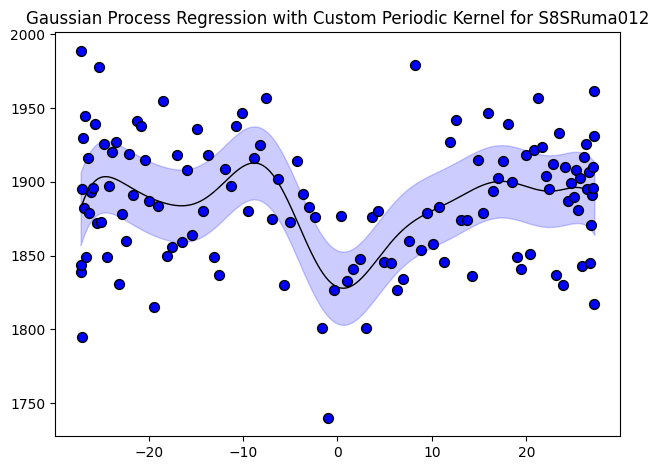

Custom Periodic kernel parameters for S8SRuma015:
Theta_1: 27.2324505078604
Theta_2: -1.5597698908895323


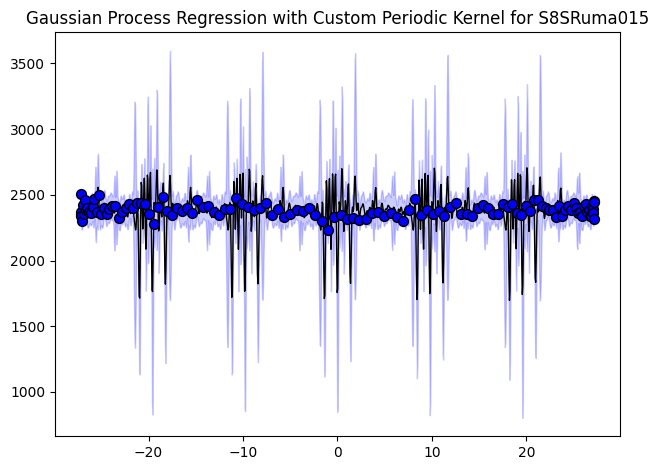

Custom Periodic kernel parameters for S8SRuma018:
Theta_1: 463.5659634497496
Theta_2: 5123.0829401042565


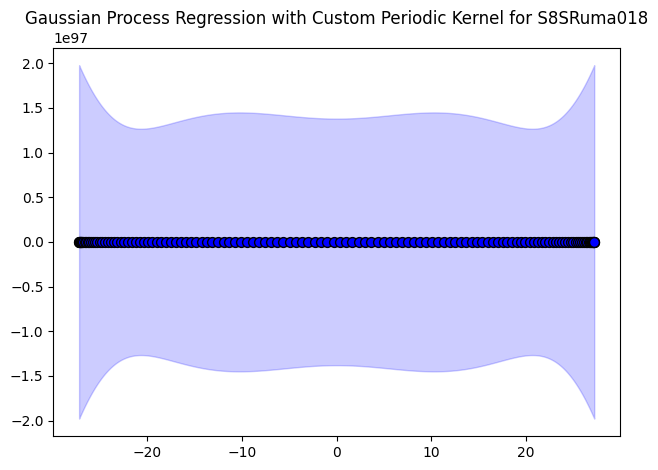

Custom Periodic kernel parameters for S8SRuma021:
Theta_1: 4.195363409857686
Theta_2: 5.880538267900906


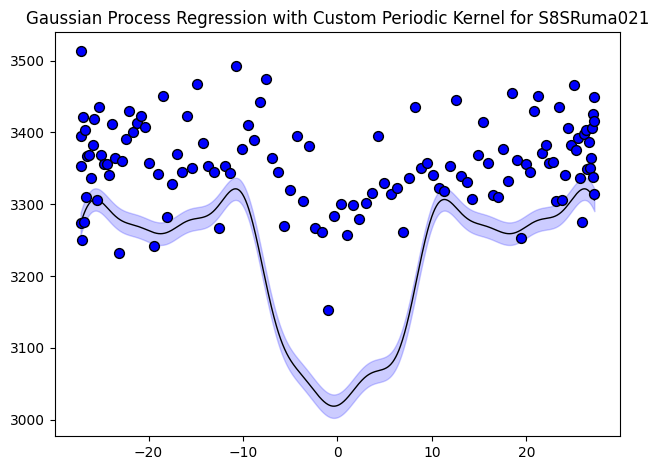

Custom Periodic kernel parameters for S8SRuma024:
Theta_1: 35.812648482563375
Theta_2: -53.14419440319704


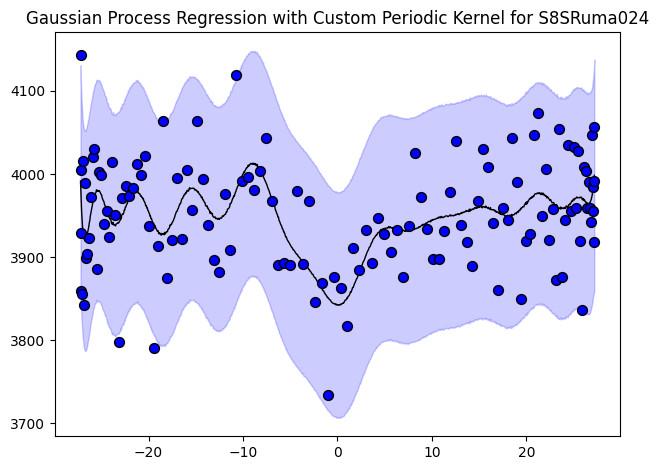

Custom Periodic kernel parameters for S8SRuma027:
Theta_1: 35.43394353202191
Theta_2: -50.64858334968398


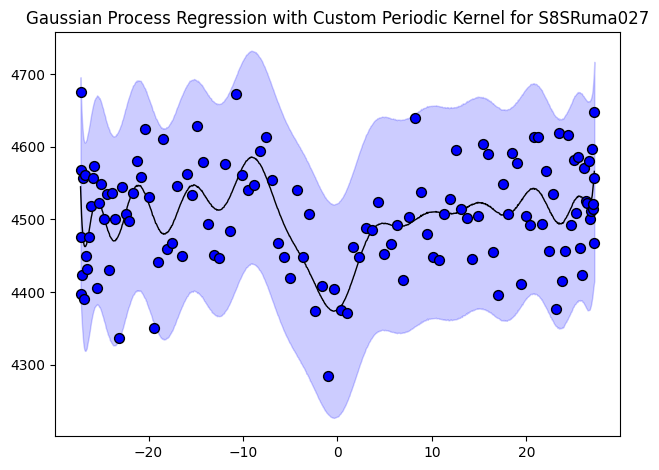

Custom Periodic kernel parameters for S8SRuma030:
Theta_1: 35.54163667186657
Theta_2: -37.98679012137204


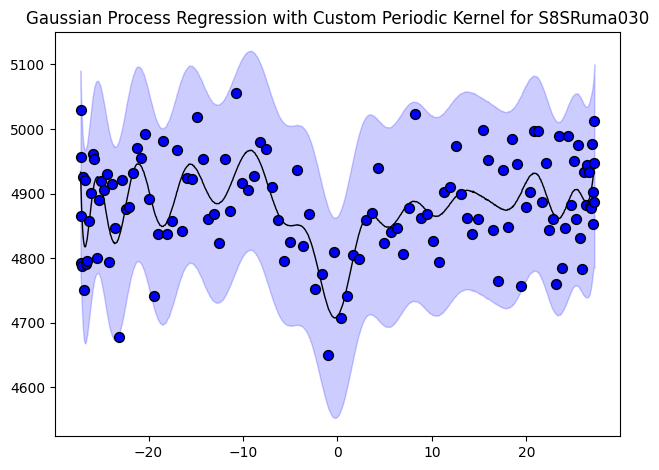

In [32]:
# 2列目以降の各列に対してガウス過程回帰を実行
for column in data.columns[1:]:
    y = data[column].values[:, np.newaxis]
    
    # カーネルのインスタンスを作成
    kernel = CustomPeriodicKernel(input_dim=1)

    # ガウス過程モデルの定義
    model = GPy.models.GPRegression(X, y, kernel)

    # モデルの最適化
    model.optimize(messages=True)

    # ハイパーパラメータの値を表示
    print(f"Custom Periodic kernel parameters for {column}:")
    print(f"Theta_1: {model.kern.theta_1[0]}")
    print(f"Theta_2: {model.kern.theta_2[0]}")

    # 予測
    X_pred = np.linspace(X.min(), X.max(), 1000)[:, np.newaxis]
    y_pred, var_pred = model.predict(X_pred)
    y_pred = y_pred.ravel()
    sigma = np.sqrt(var_pred).ravel()

    # 結果のプロット
    plt.figure()
    plt.plot(X_pred, y_pred, 'k', lw=1)
    plt.fill_between(X_pred.ravel(), y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='b')
    plt.scatter(X, y, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.title(f"Gaussian Process Regression with Custom Periodic Kernel for {column}")
    plt.tight_layout()
    plt.show()